# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 99.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import optuna
import shutil
import json
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e6/train.csv"
    test_path = "/kaggle/input/playground-series-s5e6/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e6/sample_submission.csv"
    
    target = "Fertilizer Name"
    n_folds = 5
    seed = 42
    
    run_optuna = False
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

cat_cols = train.select_dtypes(include="object").columns.tolist()
cat_cols = [c for c in cat_cols if c != CFG.target]
train[cat_cols] = train[cat_cols].astype(str).astype("category")
test[cat_cols] = test[cat_cols].astype(str).astype("category")

label_encoder = LabelEncoder()
train[CFG.target] = label_encoder.fit_transform(train[CFG.target])

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

In [5]:
mutual_info = mutual_info_classif(X, y, random_state=CFG.seed, discrete_features=True)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Moisture,0.003308
Phosphorous,0.002984
Nitrogen,0.002373
Crop Type,0.002088
Potassium,0.001367
Humidity,0.001015
Temparature,0.000966
Soil Type,0.000617


# Training base models

In [6]:
def map3(y_true, y_pred_probs):
    y_true = [[x] for x in y_true]
    y_pred_probs = np.argsort(y_pred_probs, axis=1)[:, -3:][:, ::-1].tolist()
    
    def ap3(y_true, y_pred_probs):
        y_pred_probs = y_pred_probs[:3]

        score = 0.0
        num_hits = 0.0

        for i,p in enumerate(y_pred_probs):
            if p in y_true and p not in y_pred_probs[:i]:
                num_hits += 1.0
                score += num_hits / (i+1.0)

        if not y_true:
            return 0.0

        return score
    
    return np.mean([ap3(a,p) for a,p in zip(y_true, y_pred_probs)])

In [7]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config

    def fit_predict(self, X, y, X_test, fit_args={}):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], y.nunique()))
        test_pred_probs = np.zeros((X_test.shape[0], y.nunique()))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            
            if fit_args:
                model.fit(X_train, y_train, **fit_args, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            if fit_args:
                print(f"\n--- Fold {fold_idx + 1} - MAP@3: {score:.6f}\n\n")
            else:
                print(f"--- Fold {fold_idx + 1} - MAP@3: {score:.6f}")
                            
        overall_score = map3(y, oof_pred_probs)
            
        print(f"\n------ Overall MAP@3: {overall_score:.6f} | Average MAP@3: {np.mean(scores):.6f} ± {np.std(scores):.6f}")
        
        return oof_pred_probs, test_pred_probs, scores

    def tune(self, X, y):        
        scores = []        
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)            
            score = map3(y_val, y_pred_probs)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
        return np.mean(scores)

In [8]:
lgbm_params = {
    "boosting_type": "gbdt",
    "device": "gpu",
    "n_estimators": 10000,
    "n_jobs": -1,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "device": "gpu",
    "n_estimators": 10000,
    "n_jobs": -1,
    "verbose": -1
}


xgb_params = {
    "device": "gpu",
    "n_estimators": 10000,
    "verbosity": 0,
    "random_state": 42,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
}

cb_params = {
    "iterations": 10000,
    "task_type": "GPU",
    "verbose": False
}

In [9]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [10]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (gbdt)"], test_pred_probs["LightGBM (gbdt)"], scores["LightGBM (gbdt)"] = lgbm_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92065
[500]	valid_0's multi_logloss: 1.91923
Early stopping, best iteration is:
[589]	valid_0's multi_logloss: 1.91903

--- Fold 1 - MAP@3: 0.331011


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92059
[500]	valid_0's multi_logloss: 1.91921
[750]	valid_0's multi_logloss: 1.91875
Early stopping, best iteration is:
[686]	valid_0's multi_logloss: 1.91866

--- Fold 2 - MAP@3: 0.331398


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.92038
[500]	valid_0's multi_logloss: 1.91849
Early stopping, best iteration is:
[622]	valid_0's multi_logloss: 1.91833

--- Fold 3 - MAP@3: 0.332151


Training until validation scores don't improve for 100 rounds
[250]	valid_0's multi_logloss: 1.9207
[500]	valid_0's multi_logloss: 1.91941
Early stopping, best iteration is:
[611]	valid_0's multi_logloss: 1.91909

--- Fold 

In [11]:
lgb_goss_model = LGBMClassifier(**lgbm_goss_params)
lgb_goss_trainer = Trainer(lgb_goss_model)

fit_args = {
    "callbacks": [
        log_evaluation(period=250), 
        early_stopping(stopping_rounds=100)
    ]
}

oof_pred_probs["LightGBM (goss)"], test_pred_probs["LightGBM (goss)"], scores["LightGBM (goss)"] = lgb_goss_trainer.fit_predict(X, y, X_test, fit_args)

Training LGBMClassifier

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 1.93135

--- Fold 1 - MAP@3: 0.311220


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's multi_logloss: 1.93055

--- Fold 2 - MAP@3: 0.313287


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	valid_0's multi_logloss: 1.93072

--- Fold 3 - MAP@3: 0.312159


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's multi_logloss: 1.9306

--- Fold 4 - MAP@3: 0.312447


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	valid_0's multi_logloss: 1.9306

--- Fold 5 - MAP@3: 0.313731



------ Overall MAP@3: 0.312569 | Average MAP@3: 0.312569 ± 0.000880


In [12]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)

fit_args = {
    "verbose": 250
}

oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, fit_args)

Training XGBClassifier

[0]	validation_0-mlogloss:1.94328
[250]	validation_0-mlogloss:1.91787
[267]	validation_0-mlogloss:1.91823

--- Fold 1 - MAP@3: 0.334688


[0]	validation_0-mlogloss:1.94315
[250]	validation_0-mlogloss:1.91715
[295]	validation_0-mlogloss:1.91779

--- Fold 2 - MAP@3: 0.336012


[0]	validation_0-mlogloss:1.94324
[250]	validation_0-mlogloss:1.91610
[279]	validation_0-mlogloss:1.91656

--- Fold 3 - MAP@3: 0.337433


[0]	validation_0-mlogloss:1.94315
[250]	validation_0-mlogloss:1.91787
[274]	validation_0-mlogloss:1.91836

--- Fold 4 - MAP@3: 0.336009


[0]	validation_0-mlogloss:1.94327
[250]	validation_0-mlogloss:1.91712
[278]	validation_0-mlogloss:1.91768

--- Fold 5 - MAP@3: 0.336724



------ Overall MAP@3: 0.336173 | Average MAP@3: 0.336173 ± 0.000911


In [13]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)

fit_args = {
    "verbose": 250,
    "early_stopping_rounds": 100,
    "use_best_model": True,
    "cat_features": cat_cols
}

oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, fit_args)

Training CatBoostClassifier

Learning rate set to 0.073354
0:	learn: 1.9452754	test: 1.9453398	best: 1.9453398 (0)	total: 5.41s	remaining: 15h 1m 28s
250:	learn: 1.9231825	test: 1.9309692	best: 1.9309692 (250)	total: 9.96s	remaining: 6m 27s
500:	learn: 1.9130367	test: 1.9274808	best: 1.9274808 (500)	total: 14.5s	remaining: 4m 35s
750:	learn: 1.9050490	test: 1.9255102	best: 1.9255102 (750)	total: 19.1s	remaining: 3m 54s
1000:	learn: 1.8975646	test: 1.9241196	best: 1.9241196 (1000)	total: 23.7s	remaining: 3m 32s
1250:	learn: 1.8906588	test: 1.9232662	best: 1.9232627 (1249)	total: 28.3s	remaining: 3m 17s
1500:	learn: 1.8840733	test: 1.9226369	best: 1.9226342 (1489)	total: 32.8s	remaining: 3m 5s
1750:	learn: 1.8778242	test: 1.9221931	best: 1.9221788 (1735)	total: 37.4s	remaining: 2m 56s
2000:	learn: 1.8718419	test: 1.9220079	best: 1.9219650 (1967)	total: 42s	remaining: 2m 47s
2250:	learn: 1.8659548	test: 1.9217777	best: 1.9217777 (2250)	total: 46.7s	remaining: 2m 40s
2500:	learn: 1.8603696

# Ensembling with LogisticRegression

In [14]:
X = pd.DataFrame(np.concatenate(list(oof_pred_probs.values()), axis=1))
X_test = pd.DataFrame(np.concatenate(list(test_pred_probs.values()), axis=1))

In [15]:
joblib.dump(X, "oof_pred_probs.pkl")
joblib.dump(X_test, "test_pred_probs.pkl")

['test_pred_probs.pkl']

In [16]:
def objective(trial):
    solver_penalty_options = [
        ('liblinear', 'l1'),
        ('liblinear', 'l2'),
        ('lbfgs', 'l2'),
        ('lbfgs', None)
    ]
    solver, penalty = trial.suggest_categorical('solver_penalty', solver_penalty_options)
    
    params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'C': trial.suggest_float('C', 0, 10),
        'tol': trial.suggest_float('tol', 1e-7, 1e-2),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'solver': solver,
        'penalty': penalty
    }
    
    model = LogisticRegression(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)


if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=250, n_jobs=-1)
    best_params = study.best_params
    
    solver, penalty = best_params['solver_penalty']
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500,
        'solver': solver,
        'penalty': penalty,
        'fit_intercept': best_params['fit_intercept'],
        'class_weight': best_params['class_weight'],
        'C': best_params['C'],
        'tol': best_params['tol']
    }
else:
    lr_params = {
        'random_state': CFG.seed,
        'max_iter': 500
    }

In [17]:
print(json.dumps(lr_params, indent=2))

{
  "random_state": 42,
  "max_iter": 500
}


In [18]:
lr_model = LogisticRegression(**lr_params)
lr_trainer = Trainer(lr_model)

_, lr_test_pred_probs, scores["LogisticRegression"] = lr_trainer.fit_predict(X, y, X_test)

Training LogisticRegression

--- Fold 1 - MAP@3: 0.335708
--- Fold 2 - MAP@3: 0.337939
--- Fold 3 - MAP@3: 0.338277
--- Fold 4 - MAP@3: 0.337830
--- Fold 5 - MAP@3: 0.337872

------ Overall MAP@3: 0.337525 | Average MAP@3: 0.337525 ± 0.000922


In [19]:
final_predictions = []
for i in np.argsort(lr_test_pred_probs)[:, -3:][:, ::-1]:
    prediction = label_encoder.inverse_transform(i)
    final_predictions.append(" ".join(prediction))

In [20]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = final_predictions
sub.to_csv(f"sub_logistic-regression_{np.mean(scores['LogisticRegression']):.6f}.csv", index=False)
sub.head()

,id,Fertilizer Name
0,750000,DAP 28-28 10-26-26
1,750001,17-17-17 20-20 10-26-26
2,750002,20-20 28-28 10-26-26
3,750003,14-35-14 Urea 17-17-17
4,750004,20-20 10-26-26 28-28


# Results

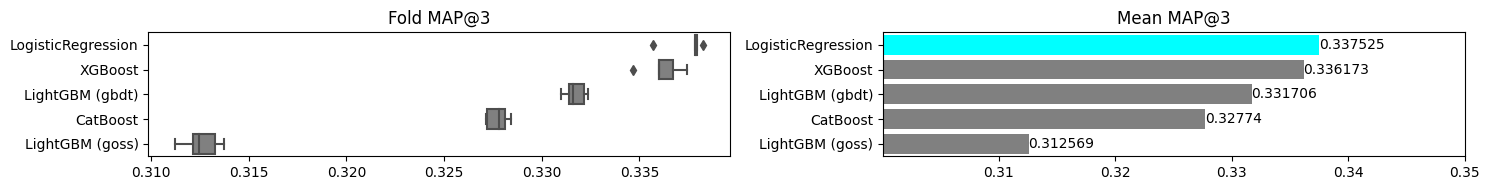

In [21]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.4))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold MAP@3")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Mean MAP@3")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "logistic" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [22]:
shutil.rmtree("catboost_info", ignore_errors=True)